# **Building Csv Files**

In [1]:
import os
import csv
import random

# Dossiers source et target
source_folder = "/kaggle/input/2d-geometric-shapes-17-shapes/2D_Geometric_Shapes_Dataset/trapezoid"
target_folder = "/kaggle/input/2d-geometric-shapes-17-shapes/2D_Geometric_Shapes_Dataset/square"

# Fichier CSV de sortie
output_csv = "trapezoid_square.csv"

# Récupération des chemins d'images
def get_image_paths(folder):
    valid_exts = {".png", ".jpg", ".jpeg", ".bmp"}
    return [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if os.path.splitext(f)[1].lower() in valid_exts
    ]

# Charger les chemins
source_images = get_image_paths(source_folder)
target_images = get_image_paths(target_folder)

# Vérifier que les dossiers contiennent des images
if not source_images or not target_images:
    raise ValueError("Un des dossiers ne contient pas d'images.")

# Créer les paires : chaque source → target aléatoire
pairs = []
for src in source_images:
    tgt = random.choice(target_images)
    pairs.append((src, tgt))

# Sauvegarde dans un fichier CSV
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["source_path", "target_path"])
    writer.writerows(pairs)

print(f"✅ Fichier CSV créé : {output_csv}")
print(f"Nombre de paires : {len(pairs)}")


✅ Fichier CSV créé : trapezoid_square.csv
Nombre de paires : 50000


# **Morphing Generation Pipeline Using SRVF**

In [3]:
import cv2
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ---------- Image Processing ----------
def extract_contour(img_path, n_points=1000):
    """Extract contour curve (Nx2) from binary image."""
    # Charger l'image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Impossible de charger l'image: {img_path}")
    
    # Appliquer un flou pour réduire le bruit
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Détecter les contours avec Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # Trouver les contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        raise ValueError("Aucun contour détecté dans l'image")
    
    # Prendre le plus grand contour
    contour = max(contours, key=cv2.contourArea).squeeze()
    
    # Si le contour a seulement 1 point, lever une erreur
    if contour.ndim == 1 or len(contour) < 10:
        raise ValueError("Contour trop petit ou dégénéré")
    
    # Rééchantillonner et normaliser
    contour = resample_curve(contour, n_points)
    contour = normalize_curve(contour)
    
    return contour

# ---------- SRVF Functions ----------
def curve_to_srvf(beta):
    """Convert curve (Nx2) to SRVF (Nx2)."""
    # Calculer les dérivées avec un pas constant
    n = len(beta)
    dt = 1.0 / n
    
    # Calculer le gradient
    beta_grad = np.gradient(beta, dt, axis=0)
    
    # Calculer les normes
    norms = np.linalg.norm(beta_grad, axis=1, keepdims=True)
    
    # Éviter la division par zéro
    norms = np.maximum(norms, 1e-8)
    
    # Calculer SRVF
    q = beta_grad / np.sqrt(norms)
    
    return q

def srvf_to_curve(q, start):
    """Reconstruct curve from SRVF q and starting point."""
    n = len(q)
    dt = 1.0 / n
    
    beta = np.zeros_like(q)
    beta[0] = start
    
    # Reconstruire la courbe par intégration
    for i in range(1, n):
        beta[i] = beta[i-1] + q[i-1] * np.linalg.norm(q[i-1]) * dt
    
    return beta

def resample_curve(curve, n=200):
    """Uniformly resample a curve to n points."""
    # Calculer la longueur cumulative le long de la courbe
    diff = np.diff(curve, axis=0)
    distances = np.sqrt(np.sum(diff**2, axis=1))
    cumulative_length = np.cumsum(distances)
    cumulative_length = np.insert(cumulative_length, 0, 0)
    
    # Éviter les longueurs nulles
    if cumulative_length[-1] == 0:
        raise ValueError("La courbe a une longueur nulle")
    
    # Rééchantillonner uniformément
    uniform_length = np.linspace(0, cumulative_length[-1], n)
    
    # Interpolation pour chaque dimension
    interpolated_curve = np.zeros((n, curve.shape[1]))
    for dim in range(curve.shape[1]):
        f = interp1d(cumulative_length, curve[:, dim], kind='linear', 
                     bounds_error=False, fill_value="extrapolate")
        interpolated_curve[:, dim] = f(uniform_length)
    
    return interpolated_curve

def normalize_curve(curve):
    """Normalize curve to have zero mean and unit norm."""
    # Centrer la courbe
    curve_centered = curve - np.mean(curve, axis=0)
    
    # Calculer la norme
    curve_norm = np.sqrt(np.sum(curve_centered**2))
    
    # Éviter la division par zéro
    if curve_norm < 1e-8:
        return curve_centered
    
    # Normaliser
    curve_normalized = curve_centered / curve_norm
    
    return curve_normalized

# ---------- Morphing Functions ----------
def compute_srvf_distance(q1, q2):
    """Compute distance between two SRVFs."""
    return np.sqrt(np.trapz(np.sum((q1 - q2)**2, axis=1), dx=1.0/len(q1)))

def align_curves(q1, q2):
    """Find optimal rotation and starting point alignment."""
    n = len(q1)
    best_distance = float('inf')
    best_q2 = q2.copy()
    
    # Essayer différentes rotations circulaires
    for shift in range(n):
        q2_shifted = np.roll(q2, shift, axis=0)
        distance = compute_srvf_distance(q1, q2_shifted)
        
        if distance < best_distance:
            best_distance = distance
            best_q2 = q2_shifted
    
    return best_q2

def generate_morphing_sequence(beta1, beta2, num_frames=5):
    """
    Generate morphing sequence between two curves using SRVF interpolation.
    
    Args:
        beta1: Source curve (Nx2)
        beta2: Target curve (Nx2)
        num_frames: Number of morphing frames (including start and end)
    
    Returns:
        List of morphed curves
    """
    # Convertir en SRVF
    q1 = curve_to_srvf(beta1)
    q2 = curve_to_srvf(beta2)
    
    # Aligner les courbes
    q2_aligned = align_curves(q1, q2)
    
    # Générer la séquence de morphing
    morph_sequence = []
    
    for t in np.linspace(0, 1, num_frames):
        # Interpolation linéaire entre les SRVFs
        q_t = (1 - t) * q1 + t * q2_aligned
        
        # Reconstruire la courbe
        # Utiliser le point de départ interpolé
        start_t = (1 - t) * beta1[0] + t * beta2[0]
        beta_t = srvf_to_curve(q_t, start_t)
        
        morph_sequence.append(beta_t)
    
    return morph_sequence

def plot_morphing_sequence(sequence, titles=None, figsize=(15, 3)):
    """
    Plot the morphing sequence.
    
    Args:
        sequence: List of curves to plot
        titles: List of titles for each subplot
        figsize: Figure size
    """
    n_frames = len(sequence)
    
    if titles is None:
        titles = [f"Frame {i+1}" for i in range(n_frames)]
    
    plt.figure(figsize=figsize)
    
    for i, curve in enumerate(sequence):
        plt.subplot(1, n_frames, i+1)
        plt.plot(curve[:, 0], curve[:, 1], 'b-', linewidth=2)
        plt.fill(curve[:, 0], curve[:, 1], alpha=0.3)
        plt.title(titles[i])
        plt.axis('equal')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def save_morphing_sequence(sequence, output_dir="morphing_frames", prefix="morph"):
    """
    Save morphing sequence as images.
    
    Args:
        sequence: List of curves
        output_dir: Output directory
        prefix: Prefix for output files
    """
    import os
    
    # Créer le dossier de sortie
    os.makedirs(output_dir, exist_ok=True)
    
    for i, curve in enumerate(sequence):
        plt.figure(figsize=(6, 6))
        plt.plot(curve[:, 0], curve[:, 1], 'b-', linewidth=3)
        plt.fill(curve[:, 0], curve[:, 1], 'blue', alpha=0.3)
        plt.axis('equal')
        plt.axis('off')
        plt.tight_layout()
        
        # Sauvegarder l'image
        # output_path = os.path.join(output_dir, f"{prefix}_{i+1:02d}.png")
        # plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close()
        
        # print(f"Saved: {output_path}")

# ---------- Main Function ----------
def create_contour_morphing(img_path1, img_path2, n_points=200, num_frames=5):
    """
    Complete pipeline for contour morphing between two images.
    
    Args:
        img_path1: Path to source image
        img_path2: Path to target image
        n_points: Number of points for resampling
        num_frames: Number of morphing frames
    
    Returns:
        morph_sequence: List of morphed curves
    """
    print("Extracting contours...")
    
    # Extraire les contours
    contour1 = extract_contour(img_path1, n_points)
    contour2 = extract_contour(img_path2, n_points)
    
    print(f"Contour 1 shape: {contour1.shape}")
    print(f"Contour 2 shape: {contour2.shape}")
    
    # Générer la séquence de morphing
    print("Generating morphing sequence...")
    morph_sequence = generate_morphing_sequence(contour1, contour2, num_frames)
    
    
    # Visualiser
    # print("Visualizing morphing sequence...")
    # titles = ["Source"] + [f"Step {i+1}" for i in range(num_frames-2)] + ["Target"]
    # plot_morphing_sequence(morph_sequence, titles)
    
    return morph_sequence



   
      

CuPy disponible: True
GPU CuPy: b'Tesla T4'
GPU setup warning: name 'torch' is not defined
Visualizing morphing sequence...


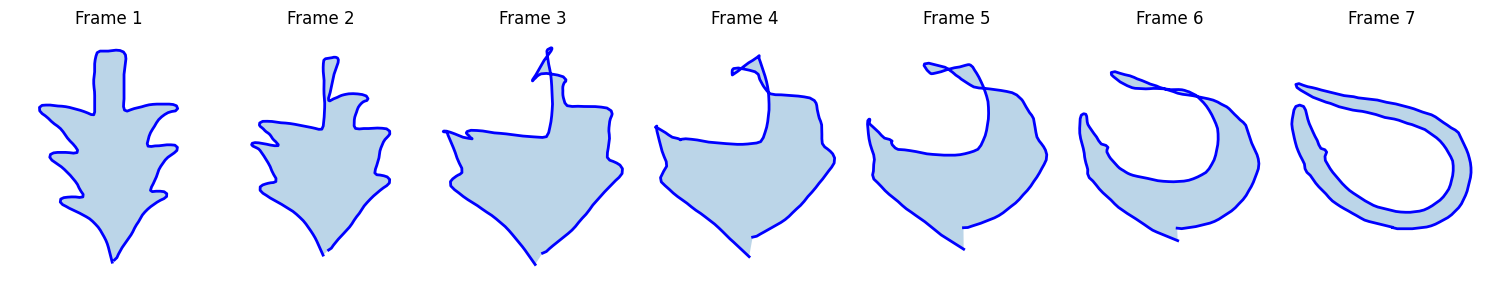

Morphing completed successfully!
Generated 7 frames


In [4]:
import cv2
import cupy as cp
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ---------- GPU Configuration ----------
def setup_gpu():
    """Configure et vérifie la disponibilité du GPU"""
    try:
        print(f"CuPy disponible: {cp.is_available()}")
        if cp.is_available():
            print(f"GPU CuPy: {cp.cuda.runtime.getDeviceProperties(0)['name']}")
        
        print(f"PyTorch GPU disponible: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"GPU PyTorch: {torch.cuda.get_device_name(0)}")
            
    except Exception as e:
        print(f"GPU setup warning: {e}")

# ---------- GPU Helper Functions ----------
def cp_insert(arr, obj, values, axis=None):
    """Alternative to numpy.insert for CuPy arrays"""
    arr_np = cp.asnumpy(arr)
    result_np = np.insert(arr_np, obj, values, axis=axis)
    return cp.asarray(result_np)

def cp_interp(x, xp, fp):
    """Alternative to numpy.interp for CuPy arrays"""
    x_np = cp.asnumpy(x)
    xp_np = cp.asnumpy(xp)
    fp_np = cp.asnumpy(fp)
    result_np = np.interp(x_np, xp_np, fp_np)
    return cp.asarray(result_np)

def cp_gradient(array, dt, axis=0):
    """Custom gradient implementation for CuPy"""
    if axis == 0:
        grad = cp.zeros_like(array)
        # Forward difference for first element
        grad[0] = (array[1] - array[0]) / dt
        # Central difference for interior elements
        grad[1:-1] = (array[2:] - array[:-2]) / (2 * dt)
        # Backward difference for last element
        grad[-1] = (array[-1] - array[-2]) / dt
    else:
        # For other axes, use numpy then convert back
        array_np = cp.asnumpy(array)
        grad_np = np.gradient(array_np, dt, axis=axis)
        grad = cp.asarray(grad_np)
    return grad

# ---------- GPU Accelerated Image Processing ----------
def extract_contour_gpu(img_path, n_points=1000):
    """Extract contour curve (Nx2) from binary image with GPU acceleration."""
    # Charger l'image sur CPU (OpenCV nécessite CPU)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Impossible de charger l'image: {img_path}")
    
    # Utiliser OpenCV pour le prétraitement (plus stable)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    # Trouver les contours sur CPU
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        raise ValueError("Aucun contour détecté dans l'image")
    
    # Prendre le plus grand contour
    contour = max(contours, key=cv2.contourArea).squeeze()
    
    if contour.ndim == 1 or len(contour) < 10:
        raise ValueError("Contour trop petit ou dégénéré")
    
    # Rééchantillonner et normaliser sur GPU
    contour_gpu = cp.asarray(contour, dtype=cp.float32)
    contour_resampled = resample_curve_gpu(contour_gpu, n_points)
    contour_normalized = normalize_curve_gpu(contour_resampled)
    
    return cp.asnumpy(contour_normalized)

# ---------- GPU Accelerated SRVF Functions ----------
def curve_to_srvf_gpu(beta):
    """Convert curve (Nx2) to SRVF (Nx2) on GPU."""
    beta_gpu = cp.asarray(beta, dtype=cp.float32)
    n = len(beta_gpu)
    dt = 1.0 / n
    
    # Calculer le gradient sur GPU
    beta_grad = cp_gradient(beta_gpu, dt, axis=0)
    
    # Calculer les normes
    norms = cp.linalg.norm(beta_grad, axis=1, keepdims=True)
    norms = cp.maximum(norms, 1e-8)
    
    # Calculer SRVF
    q = beta_grad / cp.sqrt(norms)
    
    return cp.asnumpy(q)

def srvf_to_curve_gpu(q, start):
    """Reconstruct curve from SRVF q and starting point on GPU."""
    q_gpu = cp.asarray(q, dtype=cp.float32)
    start_gpu = cp.asarray(start, dtype=cp.float32)
    
    n = len(q_gpu)
    dt = 1.0 / n
    
    beta = cp.zeros_like(q_gpu)
    beta[0] = start_gpu
    
    # Reconstruire la courbe par intégration sur GPU
    for i in range(1, n):
        step = q_gpu[i-1] * cp.linalg.norm(q_gpu[i-1]) * dt
        beta[i] = beta[i-1] + step
    
    return cp.asnumpy(beta)

def resample_curve_gpu(curve, n=200):
    """Uniformly resample a curve to n points on GPU."""
    curve_gpu = cp.asarray(curve, dtype=cp.float32)
    
    # Calculer la longueur cumulative sur GPU
    diff = cp.diff(curve_gpu, axis=0)
    distances = cp.sqrt(cp.sum(diff**2, axis=1))
    cumulative_length = cp.cumsum(distances)
    cumulative_length = cp_insert(cumulative_length, 0, 0)  # Use our custom insert
    
    if cumulative_length[-1] == 0:
        raise ValueError("La courbe a une longueur nulle")
    
    # Rééchantillonner uniformément
    uniform_length = cp.linspace(0, cumulative_length[-1], n)
    
    # Interpolation sur GPU avec notre fonction custom
    interpolated_curve = cp.zeros((n, curve_gpu.shape[1]), dtype=cp.float32)
    
    for dim in range(curve_gpu.shape[1]):
        interpolated_curve[:, dim] = cp_interp(uniform_length, cumulative_length, curve_gpu[:, dim])
    
    return cp.asnumpy(interpolated_curve)

def normalize_curve_gpu(curve):
    """Normalize curve to have zero mean and unit norm on GPU."""
    curve_gpu = cp.asarray(curve, dtype=cp.float32)
    
    # Centrer la courbe
    curve_mean = cp.mean(curve_gpu, axis=0)
    curve_centered = curve_gpu - curve_mean
    
    # Calculer la norme
    curve_norm = cp.sqrt(cp.sum(curve_centered**2))
    
    if curve_norm < 1e-8:
        return cp.asnumpy(curve_centered)
    
    # Normaliser
    curve_normalized = curve_centered / curve_norm
    
    return cp.asnumpy(curve_normalized)

# ---------- GPU Accelerated Morphing Functions ----------
def compute_srvf_distance_gpu(q1, q2):
    """Compute distance between two SRVFs on GPU."""
    q1_gpu = cp.asarray(q1, dtype=cp.float32)
    q2_gpu = cp.asarray(q2, dtype=cp.float32)
    
    diff = q1_gpu - q2_gpu
    squared_diff = cp.sum(diff**2, axis=1)
    
    # Implémentation manuelle de trapz
    n = len(squared_diff)
    dx = 1.0 / n
    integral = cp.sum((squared_diff[:-1] + squared_diff[1:]) / 2 * dx)
    distance = cp.sqrt(integral)
    
    return float(cp.asnumpy(distance))

def align_curves_gpu(q1, q2):
    """Find optimal rotation and starting point alignment on GPU."""
    q1_gpu = cp.asarray(q1, dtype=cp.float32)
    q2_gpu = cp.asarray(q2, dtype=cp.float32)
    
    n = len(q1_gpu)
    best_distance = float('inf')
    best_q2 = cp.asnumpy(q2_gpu)
    
    # Essayer différentes rotations circulaires sur GPU
    for shift in range(0, n, max(1, n//100)):  # Sample every 1% for speed
        q2_shifted = cp.roll(q2_gpu, shift, axis=0)
        distance = compute_srvf_distance_gpu(cp.asnumpy(q1_gpu), cp.asnumpy(q2_shifted))
        
        if distance < best_distance:
            best_distance = distance
            best_q2 = cp.asnumpy(q2_shifted)
    
    return best_q2

def generate_morphing_sequence_gpu(beta1, beta2, num_frames=5):
    """
    Generate morphing sequence between two curves using SRVF interpolation on GPU.
    """
    # Convertir en SRVF sur GPU
    q1 = curve_to_srvf_gpu(beta1)
    q2 = curve_to_srvf_gpu(beta2)
    
    # Aligner les courbes sur GPU
    q2_aligned = align_curves_gpu(q1, q2)
    
    # Générer la séquence de morphing sur GPU
    morph_sequence = []
    
    for t in np.linspace(0, 1, num_frames):
        # Interpolation linéaire entre les SRVFs
        q_t = (1 - t) * q1 + t * q2_aligned
        
        # Point de départ interpolé
        start_t = (1 - t) * beta1[0] + t * beta2[0]
        
        # Reconstruire la courbe sur GPU
        beta_t = srvf_to_curve_gpu(q_t, start_t)
        morph_sequence.append(beta_t)
    
    return morph_sequence

# ---------- Batch Processing for Maximum GPU Utilization ----------
def process_batch_morphings_gpu(image_pairs, n_points=200, num_frames=5, batch_size=10):
    """
    Process multiple morphing sequences in batch on GPU.
    """
    results = []
    
    for batch_start in range(0, len(image_pairs), batch_size):
        batch_end = min(batch_start + batch_size, len(image_pairs))
        batch_pairs = image_pairs[batch_start:batch_end]
        
        print(f"Processing batch {batch_start//batch_size + 1}/{(len(image_pairs)-1)//batch_size + 1}")
        
        for i, (img1_path, img2_path) in enumerate(batch_pairs):
            try:
                morph_sequence = create_contour_morphing_gpu(
                    img1_path, 
                    img2_path, 
                    n_points=n_points, 
                    num_frames=num_frames
                )
                
                results.append({
                    'pair_id': batch_start + i,
                    'source_path': img1_path,
                    'target_path': img2_path,
                    'morph_sequence': morph_sequence,
                    'status': 'success'
                })
                
            except Exception as e:
                print(f"Error processing pair {batch_start + i}: {e}")
                results.append({
                    'pair_id': batch_start + i,
                    'source_path': img1_path,
                    'target_path': img2_path,
                    'error': str(e),
                    'status': 'failed'
                })
    
    return results

# ---------- Updated Main Function with GPU ----------
def create_contour_morphing_gpu(img_path1, img_path2, n_points=200, num_frames=5):
    """
    Complete pipeline for contour morphing between two images with GPU acceleration.
    """
    # Extraire les contours avec GPU
    contour1 = extract_contour_gpu(img_path1, n_points)
    contour2 = extract_contour_gpu(img_path2, n_points)
    
    # Générer la séquence de morphing avec GPU
    morph_sequence = generate_morphing_sequence_gpu(contour1, contour2, num_frames)
    
    return morph_sequence

# ---------- Fallback System ----------
def create_contour_morphing(img_path1, img_path2, n_points=200, num_frames=5, use_gpu=True):
    """
    Universal function that tries GPU first, falls back to CPU if needed.
    """
    if use_gpu and cp.is_available():
        try:
            return create_contour_morphing_gpu(img_path1, img_path2, n_points, num_frames)
        except Exception as e:
            print(f"GPU processing failed, falling back to CPU: {e}")
    
    # Fallback to CPU implementation
    return create_contour_morphing_cpu(img_path1, img_path2, n_points, num_frames)

# ---------- Example Usage ----------
if __name__ == "__main__":
    setup_gpu()
    
    img1_path = "/kaggle/input/testdata/tree-2.gif"
    img2_path = "/kaggle/input/testdata/sea_snake-6.gif"
    
    try:
        # Créer le morphing avec GPU (fallback automatique vers CPU si échec)
        morph_sequence = create_contour_morphing(
            img1_path, 
            img2_path, 
            n_points=200, 
            num_frames=7,
            use_gpu=True
        )
            # Visualiser
        print("Visualizing morphing sequence...")
        # titles = ["Source"] + [f"Step {i+1}" for i in range(num_frames-2)] + ["Target"]
        plot_morphing_sequence(morph_sequence)
    
        print("Morphing completed successfully!")
        print(f"Generated {len(morph_sequence)} frames")
        
    except Exception as e:
        print(f"Error: {e}")

In [5]:
# ---------- Example Usage ----------
if __name__ == "__main__":
    # Exemple d'utilisation
    img1_path = "/kaggle/input/2d-geometric-shapes-17-shapes/2D_Geometric_Shapes_Dataset/star/star_10013.png"  # Remplacez par votre chemin d'image
    img2_path = "/kaggle/input/2d-geometric-shapes-17-shapes/2D_Geometric_Shapes_Dataset/triangle/triangle_100.png"  # Remplacez par votre chemin d'image
    
    try:
        # Créer le morphing
        morph_sequence = create_contour_morphing(
            img1_path, 
            img2_path, 
            n_points=200, 
            num_frames=20
        )
        
        # Sauvegarder les images
        save_morphing_sequence(morph_sequence, "morphing_results")
        
        print("Morphing completed successfully!")
        
    except Exception as e:
        print(f"Error: {e}")

Morphing completed successfully!


# **Building Json Data**

In [12]:
# import pandas as pd
# import os

# # Charger ton DataFrame (si déjà chargé, ignore cette ligne)
# df = pd.read_csv("/kaggle/input/csv-path-pairs/merged_shuffled (1).csv")  # ou remplace par ton fichier d'origine

# # Extraire uniquement le nom du fichier à partir du chemin
# df["source_id"] = df["source_path"].apply(lambda x: os.path.basename(x))
# df["target_id"] = df["target_path"].apply(lambda x: os.path.basename(x))

# # Sauvegarder le DataFrame modifié dans un nouveau CSV
# df.to_csv("merged_paths", index=False, encoding="utf-8")

# print("✅ Fichier sauvegardé sous 'merged_paths.csv'")
# df.head()


✅ Fichier sauvegardé sous 'merged_paths.csv'


,source_path,target_path,source_id,target_id
0,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,square_2964.png,star_41696.png
1,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,star_26943.png,circle_46932.png
2,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,star_45556.png,circle_46646.png
3,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,circle_24679.png,trapezoid_15006.png
4,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,/kaggle/input/2d-geometric-shapes-17-shapes/2D...,square_28747.png,star_34082.png


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   source_path  600000 non-null  object
 1   target_path  600000 non-null  object
 2   source_id    600000 non-null  object
 3   target_id    600000 non-null  object
dtypes: object(4)
memory usage: 18.3+ MB


In [6]:
# ---------- Nouvelle fonction pour traiter le CSV ----------
def process_csv_to_single_json(csv_path, output_json_path, n_points=200, num_frames=7, max_samples=None):
    """
    Traite un fichier CSV et crée un seul fichier JSON avec toutes les séquences de morphing.
    
    Args:
        csv_path (str): Chemin vers le fichier CSV
        output_json_path (str): Chemin pour le fichier JSON de sortie
        n_points (int): Nombre de points pour le rééchantillonnage
        num_frames (int): Nombre de frames de morphing
        max_samples (int): Nombre maximum d'échantillons à traiter (optionnel)
    """
    
    # Charger le CSV
    print("Chargement du CSV...")
    df = pd.read_csv(csv_path)
    
    # Limiter le nombre d'échantillons si spécifié
    if max_samples is not None:
        df = df.head(max_samples)
    
    total_samples = len(df)
    print(f"Nombre total de paires à traiter: {total_samples}")
    
    # Structure pour stocker toutes les données
    dataset = {
        "metadata": {
            "total_pairs": total_samples,
            "n_points": n_points,
            "num_frames": num_frames,
            "processed_pairs": 0,
            "failed_pairs": 0
        },
        "morphing_sequences": {}
    }
    
    successful_pairs = 0
    failed_pairs = 0
    
    # Traiter chaque paire
    for index, row in df.iterrows():
        pair_id = f"{row['source_id']}_{row['target_id']}"
        
        print(f"Traitement de la paire {index+1}/{total_samples}: {pair_id}")
        
        try:
            # Générer la séquence de morphing
            morph_sequence = create_contour_morphing(
                row['source_path'],
                row['target_path'],
                n_points=n_points,
                num_frames=num_frames
            )
            
            # Convertir en liste pour JSON (numpy arrays → list)
            morph_sequence_list = [frame.tolist() for frame in morph_sequence]
            
            # Stocker dans le dataset
            dataset["morphing_sequences"][pair_id] = {
                "source_id": row['source_id'],
                "target_id": row['target_id'],
                "source_path": row['source_path'],
                "target_path": row['target_path'],
                "morphing_sequence": morph_sequence_list,
                "sequence_shape": {
                    "num_frames": num_frames,
                    "points_per_frame": n_points,
                    "dimensions": 2
                }
            }
            
            successful_pairs += 1
            print(f"✓ Succès: {pair_id}")
            
        except Exception as e:
            failed_pairs += 1
            print(f"✗ Échec: {pair_id} - Erreur: {str(e)}")
            
            # Stocker les informations d'erreur
            dataset["morphing_sequences"][pair_id] = {
                "source_id": row['source_id'],
                "target_id": row['target_id'],
                "source_path": row['source_path'],
                "target_path": row['target_path'],
                "error": str(e),
                "status": "failed"
            }
        
        # Sauvegarde intermédiaire toutes les 1000 paires
        if (index + 1) % 1000 == 0:
            print(f"Sauvegarde intermédiaire après {index + 1} paires...")
            dataset["metadata"]["processed_pairs"] = index + 1
            dataset["metadata"]["successful_pairs"] = successful_pairs
            dataset["metadata"]["failed_pairs"] = failed_pairs
            
            with open(output_json_path, 'w') as f:
                json.dump(dataset, f, indent=2)
    
    # Mettre à jour les métadonnées finales
    dataset["metadata"]["processed_pairs"] = total_samples
    dataset["metadata"]["successful_pairs"] = successful_pairs
    dataset["metadata"]["failed_pairs"] = failed_pairs
    
    # Sauvegarder le fichier JSON final
    print("Sauvegarde finale du fichier JSON...")
    with open(output_json_path, 'w') as f:
        json.dump(dataset, f, indent=2)
    
    print(f"✓ Traitement terminé!")
    print(f"Paires traitées avec succès: {successful_pairs}/{total_samples}")
    print(f"Paires échouées: {failed_pairs}/{total_samples}")
    print(f"Fichier JSON sauvegardé: {output_json_path}")
    
    return dataset

# ---------- Fonction pour charger les données ----------
def load_morphing_dataset(json_path):
    """
    Charge le dataset de morphing depuis le fichier JSON.
    
    Args:
        json_path (str): Chemin vers le fichier JSON
    
    Returns:
        dict: Dataset chargé
    """
    with open(json_path, 'r') as f:
        dataset = json.load(f)
    
    return dataset

def get_successful_sequences(dataset):
    """
    Retourne uniquement les séquences qui ont réussi.
    
    Args:
        dataset (dict): Dataset chargé
    
    Returns:
        dict: Séquences réussies seulement
    """
    successful_sequences = {}
    
    for pair_id, sequence_data in dataset["morphing_sequences"].items():
        if "error" not in sequence_data and "morphing_sequence" in sequence_data:
            successful_sequences[pair_id] = sequence_data
    
    return successful_sequences




In [ ]:
import json
import pandas as pd
if __name__ == "__main__":
    # Chemins
    csv_path = "/kaggle/input/csv-path-pairs/merged_paths.csv"  # Remplacez par votre chemin
    output_json_path = "morphing_dataset_complet.json"
    
    # Paramètres
    N_POINTS = 200
    NUM_FRAMES = 7
    MAX_SAMPLES = 80000  # Mettez None pour traiter tout le CSV, ou un nombre pour tester
    
    print("=== DÉBUT DU TRAITEMENT DU CSV ===")
    
    # Traiter le CSV et créer le JSON unique
    dataset = process_csv_to_single_json(
        csv_path=csv_path,
        output_json_path=output_json_path,
        n_points=N_POINTS,
        num_frames=NUM_FRAMES,
        max_samples=MAX_SAMPLES  # Mettez None pour tout traiter
    )
    
    # Charger et vérifier les données
    print("\n=== VÉRIFICATION DES DONNÉES ===")
    loaded_dataset = load_morphing_dataset(output_json_path)
    successful_sequences = get_successful_sequences(loaded_dataset)
    
    print(f"Total séquences dans le fichier: {len(loaded_dataset['morphing_sequences'])}")
    print(f"Séquences réussies: {len(successful_sequences)}")
    
    # # Afficher un exemple
    # if successful_sequences:
    #     first_key = list(successful_sequences.keys())[0]
    #     example = successful_sequences[first_key]
    #     print(f"\nExemple de séquence réussie:")
    #     print(f"ID: {first_key}")
    #     print(f"Source: {example['source_id']}")
    #     print(f"Target: {example['target_id']}")
    #     print(f"Shape de la séquence: {len(example['morphing_sequence'])} frames")
    #     print(f"Points par frame: {len(example['morphing_sequence'][0])}")

=== DÉBUT DU TRAITEMENT DU CSV ===
Chargement du CSV...
Nombre total de paires à traiter: 80000
Traitement de la paire 1/80000: square_2964.png_star_41696.png
✓ Succès: square_2964.png_star_41696.png
Traitement de la paire 2/80000: star_26943.png_circle_46932.png
✓ Succès: star_26943.png_circle_46932.png
Traitement de la paire 3/80000: star_45556.png_circle_46646.png
✓ Succès: star_45556.png_circle_46646.png
Traitement de la paire 4/80000: circle_24679.png_trapezoid_15006.png
GPU processing failed, falling back to CPU: Aucun contour détecté dans l'image
✗ Échec: circle_24679.png_trapezoid_15006.png - Erreur: name 'create_contour_morphing_cpu' is not defined
Traitement de la paire 5/80000: square_28747.png_star_34082.png
GPU processing failed, falling back to CPU: Aucun contour détecté dans l'image
✗ Échec: square_28747.png_star_34082.png - Erreur: name 'create_contour_morphing_cpu' is not defined
Traitement de la paire 6/80000: trapezoid_26117.png_star_11742.png
✓ Succès: trapezoid_261

Paire : square_16476.png_star_43567.png
Nombre de frames : 7
Shape d'une frame : (200, 2)


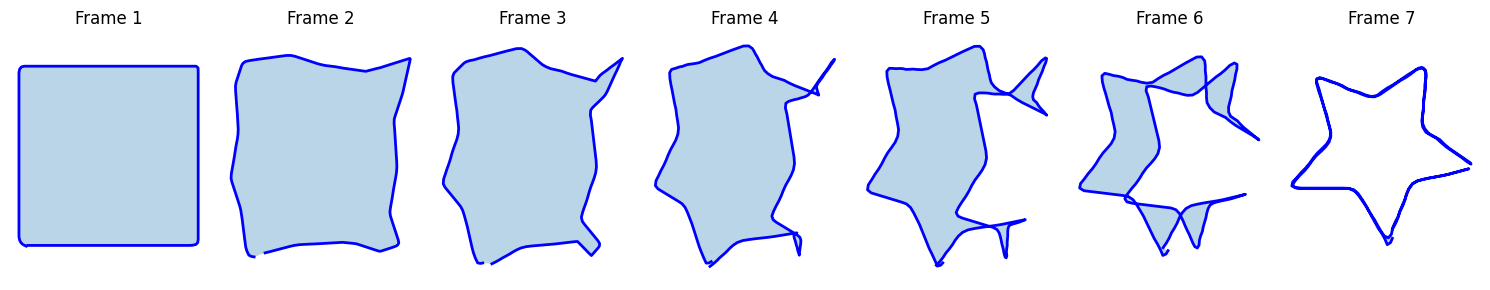

In [8]:
import json
import numpy as np

# Charger le fichier JSON
with open("/kaggle/working/morphing_dataset_complet.json", "r") as f:
    data = json.load(f)

# Extraire la première séquence
morph_sequences = data["morphing_sequences"]
first_key = list(morph_sequences.keys())[2001]
first_sequence = morph_sequences[first_key]["morphing_sequence"]

# ✅ Conversion en liste de np.array
first_sequence_np = [np.array(frame) for frame in first_sequence]

# (Optionnel) Afficher quelques infos
print(f"Paire : {first_key}")
print(f"Nombre de frames : {len(first_sequence_np)}")
print(f"Shape d'une frame : {first_sequence_np[0].shape}")

#Afficher le morphing
plot_morphing_sequence(first_sequence_np)

